In [1]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns 

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


from PIL import Image 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import glob
import time 



# seed 
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# dataset
dataset = '../input/covid-19-x-ray-10000-images/dataset'

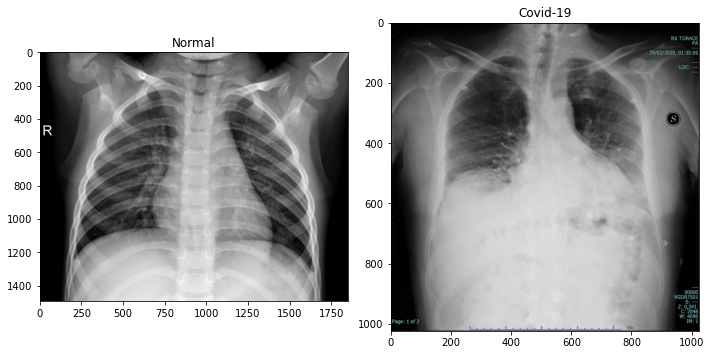

In [3]:
# spliting images 
normal_images = []

for img_path in glob.glob(dataset + '/normal/*'):
  normal_images.append(mpimg.imread(img_path))



plt.figure(figsize=(10,5))


plt.subplot(1,2,1)
plt.title('Normal')
plt.imshow(normal_images[0], cmap='gray')




covid_images = []

for img_path in glob.glob(dataset + '/covid/*'):
  covid_images.append(mpimg.imread(img_path))

plt.subplot(1,2,2)
plt.title('Covid-19')
plt.imshow(covid_images[0], cmap='gray')
plt.tight_layout()

In [4]:
# size of class images  
print('Normal: ', len(normal_images))
print('Covid: ', len(covid_images))

Normal:  28
Covid:  70


In [5]:
# define shape 
image_height = 150
image_width = 150
channels = 3 


# parameters 
input_shape = (image_height, image_width, channels)
number_classe = 2 
batch_size = 6
epochs = 40
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Text(0.5, 1.0, 'Normal')

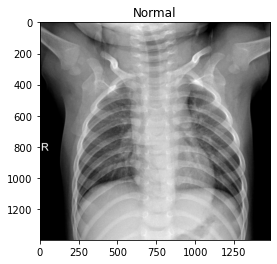

In [6]:
plt.imshow(normal_images[10], cmap='gray')
plt.title('Normal')

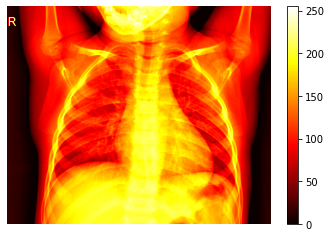

In [7]:
plt.imshow(normal_images[7], cmap='hot')
plt.axis('off')
plt.colorbar()

<br>
<br>


### 2. Convolutional Neural Network 

I decided choose for Convolutional Neural Networks, who are one  architecture who have best performance results when works on images.Beyond consistent and default in problems of images classification.


I will explain a little about the architecture that I set up and explain the use of the main layers of the network and why I chose to use it.


#### <b> Architecture </b>


* Input layer is responsible for receiving images (150x150x3) 
* Conv2D with 32 filters, kernel_size=(3,3) and padding='same'
* MaxPool2D with pool_size=(2,2)
* <b> LayerNormalization </b> This is one technique of normalization, substitute the BatchNormalization, in addition to being faster in calculating gradients and optimizing, it gets good results with it its specificity is pixel normalization done by channel and not by mini-batch.
* Conv2D with 64 filters, kernel_size=(3,3) and padding='same'
* MaxPool2D with pool_size=(2,2)
* <b> SpartialDropout2D </b> This layer was necessary for control Overfitting, by terms little images, the risk of overfitting it was biggest, SpartialDropout2D is one variant of dropout, but Spartial is very better for Feature maps, because he drops pixels after MaxPooling.
* Conv2D with 128 filters, kernel_size=(3,3) and padding='same'
* MaxPool2D with pool_size=(2,2)
* LayerNormalization again other normalization
* Conv2D with 256 filters, kernel_size=(3,3) and padding='same'
* MaxPool2D with pool_size=(2,2)
* SpartialDropout2D again other dropout
* Conv2D with 512 filters, kernel_size=(3,3) and padding='same'
* MaxPool2D with pool_size=(2,2)
* LayerNormalization again other normalization
* <b> GlobalMaxPool2D </b> I used layer GlobalMaxPool for decrease a number of parameters of network, different of Flatten this layer reduce Feature maps in Global scale, making a summary by channel of images, very good layer.
* Dense layer with 128 neurons and relu activation 
* Dense layer again for the output layer in architecture 


<br>
<br>


 











In [8]:
# Convolutional Neural Network 

model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape),
                                    tf.keras.layers.Conv2D(32, (3,3), (1,1), padding='same', activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.LayerNormalization(axis=-1),
                                    tf.keras.layers.Conv2D(64, (3,3), (1,1), padding='same', activation='relu'),                                   
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.SpatialDropout2D(0.20),
                                    tf.keras.layers.Conv2D(128, (3,3), (1,1), padding='same', activation='relu'),                                   
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.LayerNormalization(axis=-1),
                                    tf.keras.layers.Conv2D(256, (3,3), (1,1), padding='same', activation='relu'),                                   
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.SpatialDropout2D(0.20),                                  
                                    tf.keras.layers.Conv2D(512, (3,3), (1,1), padding='same', activation='relu'),
                                    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                                    tf.keras.layers.LayerNormalization(axis=-1),
                                    tf.keras.layers.GlobalMaxPool2D(),
                                    tf.keras.layers.Dense(units=128, activation='relu'),
                                    tf.keras.layers.Dense(units=1, activation='sigmoid')
                                    ])


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 75, 75, 32)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

<hr>
<br>
<br>


### 3. Data Augmentation 


Data Augmentation encompasses a suite of techniques that enhance the size and quality of training datasets such that better Deep Learning models can be built using them. The image augmentation algorithms discussed in this survey include geometric transformations, color space augmentations, kernel filters, mixing images, random erasing, feature space augmentation.



<br>





In [9]:
# Data Augmentation 
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    zoom_range=0.10,
                                    rescale = 1./255,
                                    validation_split=0.30)


# Train 
train_generator = data_generator.flow_from_directory(dataset,
                                                     target_size=(image_height, image_width),
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     subset='training')


# Validation 
validation_generator = data_generator.flow_from_directory(dataset,
                                                     target_size=(image_height, image_width),
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=False,
                                                     subset='validation')



# CNN 
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs)

Found 69 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/40
12/12 [==============================] - 5s 435ms/step - loss: 0.7037 - accuracy: 0.6812 - val_loss: 0.8776 - val_accuracy: 0.7241
Epoch 2/40
12/12 [==============================] - 5s 398ms/step - loss: 0.6049 - accuracy: 0.7246 - val_loss: 0.3567 - val_accuracy: 0.8621
Epoch 3/40
12/12 [==============================] - 5s 412ms/step - loss: 0.2152 - accuracy: 0.8841 - val_loss: 0.5329 - val_accuracy: 0.8276
Epoch 4/40
12/12 [==============================] - 5s 401ms/step - loss: 0.4562 - accuracy: 0.8406 - val_loss: 0.3948 - val_accuracy: 0.8621
Epoch 5/40
12/12 [==============================] - 5s 404ms/step - loss: 0.3316 - accuracy: 0.8551 - val_loss: 0.2616 - val_accuracy: 0.9310
Epoch 6/40
12/12 [==============================] - 5s 401ms/step - loss: 0.2002 - accuracy: 0.9130 - val_loss: 0.3827 - val_accuracy: 0.8966
Epoch 7/40
12/12 [==============================] - 5s 408ms/step - 

<br>
<hr>
<br>


### 4. Evaluation CNN 



<br>
<br>

In [10]:
print("Accuracy Test -  ", model.evaluate(validation_generator)[1]*100, '%')

5/5 [==============================] - 1s 185ms/step - loss: 0.2780 - accuracy: 0.9655
Accuracy Test -   96.55172228813171 %


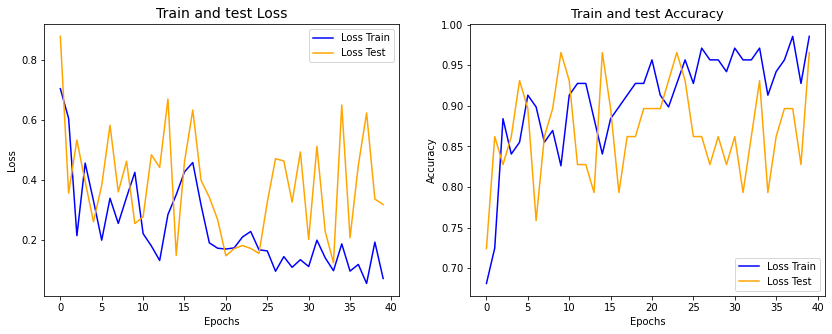

In [11]:
epochs = [i for i in range(40)]
loss_train = history.history['loss']
acc_train = history.history['accuracy']
loss_test = history.history['val_loss']
acc_test = history.history['val_accuracy']


fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(epochs, loss_train, color='blue', label='Loss Train')
ax[0].plot(epochs, loss_test, color='orange', label='Loss Test')
ax[0].set_title('Train and test Loss', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()



ax[1].plot(epochs, acc_train, color='blue', label='Loss Train')
ax[1].plot(epochs, acc_test, color='orange',  label='Loss Test')
ax[1].set_title('Train and test Accuracy', fontsize=13)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [12]:
# true class
y_test = validation_generator.classes

In [13]:
y_pred = model.predict(validation_generator)
y_pred = np.around(y_pred, decimals=0)

In [14]:
print(classification_report(y_test, y_pred, target_names=['Covid-19','Normal']))

              precision    recall  f1-score   support

    Covid-19       0.95      0.86      0.90        21
      Normal       0.70      0.88      0.78         8

    accuracy                           0.86        29
   macro avg       0.82      0.87      0.84        29
weighted avg       0.88      0.86      0.87        29



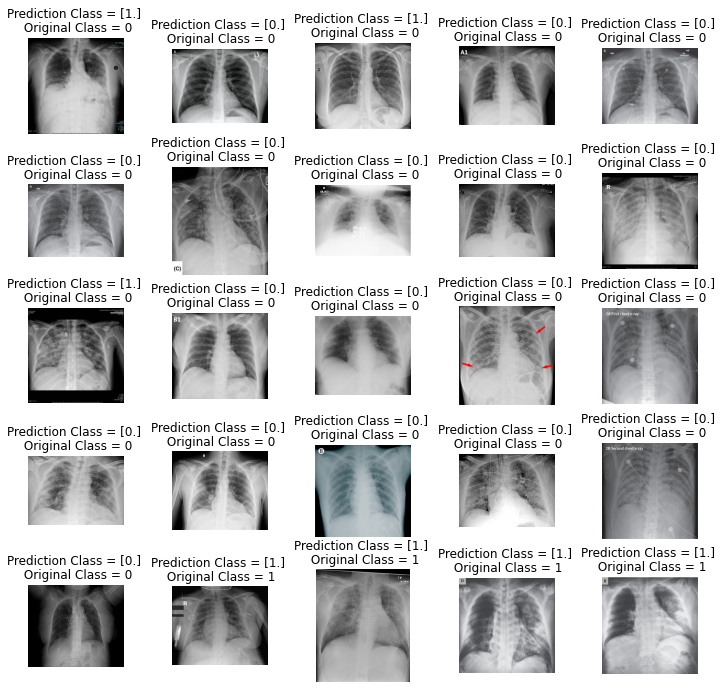

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(12,12))
axs=axs.ravel()

for i in range(0,25):  
    axs[i].imshow(covid_images[i], cmap='gray')
    axs[i].set_title("Prediction Class = {} \n Original Class = {}".format(y_pred[i], y_test[i]))
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.5)

<br>
<br>
<hr>
<br>

### Summary 
<br>

The network at the end proved to be very unstable because it had few images, but after the data increase the convolutional network showed <b> 86% accuracy </b> in the test data with a Precision of <b> 95% </b> > what is a great result, but the detail is in the variance and instability that the model has.

<br>


The reason for I develop this project, was for apply techniques of Computer Vision with Data Augmentation and also experiment diverses layers as LayerNormalization, SpartialDropout2D and GlobalMaxPool2D. 

<br>

This projetc allied with a doctor and health specialist, have big potential to be one Images Detector of Covid-19  apply a Healthcare.

The biggest problem I encountered was the small dataset of images of x-rays classified with covid-19, only 70 images is very little for this problem 

